In [24]:
#Package loading
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from sklearn import decomposition
#from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-notebook')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
from sklearn.metrics import confusion_matrix

In [25]:
#CSV loading
#Data loading
dataset2 = pd.read_csv('Z1 - lastweek-P1MC5W1.csv', index_col = 'Unnamed: 0', parse_dates = ['LastInvoice', 'Timestamp'])
#print(dataset2.columns.values)
dataset2.shape


(17833, 112)

In [26]:
#CSV loading from api
#Data loading
#dataset2 = pd.read_csv('status.csv', index_col = 'Unnamed: 0', parse_dates = ['LastInvoice', 'Timestamp'])
#print(dataset2.columns.values)
#dataset2.shape


In [27]:
#Copy of the CSV file
dataset = dataset2
dataset.shape

(17833, 112)

In [28]:
#downsampling for test
dataset = dataset2.sample(n=1000)
dataset.shape

(1000, 112)

In [29]:
#Data split per RFM code
dataset[['Timestamp', 'RFMDC']].groupby('RFMDC').count().sort_values('Timestamp').head()

,Timestamp
RFMDC,
24241,1
32432,1
22342,1
22341,1
33232,1


In [30]:
#datastamping addition on dataset
dataset['Weekday'] = dataset['Timestamp'].apply(lambda x: x.weekday())

dataset[['Weekday', 'Timestamp']].head()

,Weekday,Timestamp
794,6,2011-12-04
1889,0,2011-12-05
299,2,2011-12-07
2366,1,2011-12-06
2029,3,2011-12-08


In [31]:
#data split per criteria
criterias = ['M', 'F', 'R', 'D', 'C']
testingsize = 0.28
testlist = []
for criteria in criterias:
    df = dataset[[criteria,'CustomerID']].groupby('CustomerID', as_index = False).nth(-1)
    df = df[[criteria,'CustomerID']].groupby(criteria)
    tempdict = df['CustomerID'].apply(set).to_dict()
    print(criteria)
    for keys, values in tempdict.items():
        rows = random.sample(list(values), int(testingsize * len(values)/len(criterias)))
        print(int(testingsize * len(values)/len(criterias)),len([x for x in rows if x not in testlist]) , len(values))
        testlist.extend([x for x in rows if x not in testlist])
len(testlist)

M
12 12 218
11 11 204
11 11 202
12 12 222
F
13 12 236
13 13 243
1 1 34
18 18 333
R
11 10 213
12 9 227
11 10 201
11 10 205
D
12 9 216
12 12 218
12 11 218
10 10 194
C
40 34 726
4 2 81
2 2 39


209

In [32]:
#labels definition
target = ['R', 'F', 'M', 'D', 'C', 'RFMDC']
variables = [x for x in dataset.columns.values if x not in ['R', 'F', 'M', 'D', 'C', 'RFMDC', 'CustomerID','LastInvoice' ,'Timestamp']]

In [33]:
#testing and training set creation
mask = dataset['CustomerID'].isin([x for x in dataset['CustomerID'].unique() if x not in testlist])
trainingset = dataset.loc[mask]
trainingset.head()

mask = dataset['CustomerID'].isin(testlist)
testingset = dataset.loc[mask]
testingset.head()



,CustomerID,LastInvoice,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,...,Weekday_6_Sunday_std,F,R,M,D,RatioCancel,C,RFMDC,Timestamp,Weekday
299,13352.0,2011-12-02 11:58:00,4,-8.70,347.98,169.640,339.28,252.210847,26.0,52,...,0.000000,2,1,3,4,-0.025643,2,12342,2011-12-07,2
2262,16954.0,2011-12-02 16:46:00,4,102.00,303.90,194.400,972.00,80.114032,49.0,129,...,135.908212,1,1,2,4,0.000000,1,11241,2011-12-07,2
1938,16374.0,2011-10-04 15:21:00,63,304.58,304.58,304.580,304.58,0.000000,196.0,196,...,0.000000,4,4,3,3,0.000000,1,44331,2011-12-07,2
2615,17611.0,2011-12-06 09:46:00,0,-12.75,301.60,153.032,1530.32,130.648878,14.6,44,...,4.031904,1,1,1,3,-0.020421,2,11132,2011-12-07,2
1544,15657.0,2011-11-17 12:19:00,15,30.00,30.00,30.000,30.00,0.000000,0.0,0,...,0.000000,4,2,4,2,0.000000,1,24421,2011-12-04,6


In [34]:
#Sets creation
Xtest = testingset[variables]
ytest = testingset[target]
Xtrain = trainingset[variables]
ytrain = trainingset[target]
Xtest.head()

,Recency,SpentMin,SpentMax,SpentMean,SpentSum,SpentStd,OrderSepMean,OrderSepMax,OrderSepMin,OrderSepStd,...,Weekday_3_Thursday_mean,Weekday_3_Thursday_std,Weekday_4_Friday_sum,Weekday_4_Friday_mean,Weekday_4_Friday_std,Weekday_6_Sunday_sum,Weekday_6_Sunday_mean,Weekday_6_Sunday_std,RatioCancel,Weekday
299,4,-8.70,347.98,169.640,339.28,252.210847,26.0,52,0,36.769553,...,0.000,0.000000,-8.70,-4.350,6.151829,0.00,0.000,0.000000,-0.025643,2
2262,4,102.00,303.90,194.400,972.00,80.114032,49.0,129,0,51.628481,...,0.000,0.000000,209.52,41.904,93.700193,303.90,60.780,135.908212,0.000000,2
1938,63,304.58,304.58,304.580,304.58,0.000000,196.0,196,196,0.000000,...,0.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,0.000000,2
2615,0,-12.75,301.60,153.032,1530.32,130.648878,14.6,44,0,14.508235,...,28.735,95.432099,424.95,42.495,69.960610,-12.75,-1.275,4.031904,-0.020421,2
1544,15,30.00,30.00,30.000,30.00,0.000000,0.0,0,0,0.000000,...,30.000,0.000000,0.00,0.000,0.000000,0.00,0.000,0.000000,0.000000,6


In [35]:
#Data standardisation
std_scale = preprocessing.StandardScaler().fit(Xtrain)
X_train_scaled = std_scale.transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)

In [36]:
#Parameter to train for definition
parametertoclass = 'R'
scorer = make_scorer(f1_score, average = 'micro')
skf = StratifiedKFold(n_splits=3)
ind_params ={'n_estimators' : 30}

In [37]:
#Gridsearch creation

step1 = { 'min_samples_split':range(2,5), 'max_depth':range(6,10) ,'max_features':['log2', 'sqrt']}
scorer = make_scorer(f1_score, average = 'micro')
rfm = RandomForestClassifier(**ind_params)
clf = GridSearchCV(rfm, step1, scoring = scorer, n_jobs = 3, cv = skf, verbose = 0, return_train_score = True)
clfresult = clf.fit(X_train_scaled, ytrain[parametertoclass])
clf.score(X_test_scaled, ytest[parametertoclass])

0.83064516129032262

In [38]:
#Best params
clf.best_params_

{'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 3}

In [39]:
clf.cv_results_

{'mean_fit_time': array([ 0.0694774 ,  0.06839943,  0.06896297,  0.07960041,  0.08021291,
         0.08174268,  0.06544471,  0.06551631,  0.06496421,  0.07724579,
         0.0779864 ,  0.08064763,  0.06939562,  0.07081755,  0.070659  ,
         0.08248146,  0.08179077,  0.08124558,  0.07024964,  0.07072028,
         0.07071964,  0.08551041,  0.07971915,  0.07813032]),
 'mean_score_time': array([ 0.00648324,  0.00478808,  0.00473634,  0.00558893,  0.00446812,
         0.0046583 ,  0.00444031,  0.00440431,  0.00451001,  0.00434597,
         0.00446701,  0.00464853,  0.00464169,  0.00453806,  0.0049208 ,
         0.00458328,  0.00466156,  0.00468302,  0.00485468,  0.00494043,
         0.00469128,  0.00466267,  0.00435559,  0.00438269]),
 'mean_test_score': array([ 0.68484043,  0.66223404,  0.62765957,  0.72739362,  0.71010638,
         0.72606383,  0.65425532,  0.68218085,  0.69946809,  0.76595745,
         0.78058511,  0.78324468,  0.69680851,  0.70744681,  0.70478723,
         0.7859042

In [40]:
#feature importance
rfm = RandomForestClassifier(**{**ind_params, **clf.best_params_})
clfresult = rfm.fit(X_train_scaled, ytrain[parametertoclass])
clfresult.feature_importances_

array([  3.01188271e-01,   9.44438220e-03,   9.93590876e-03,
         8.77796600e-03,   1.09472238e-02,   1.21322072e-02,
         1.04133031e-02,   1.36406938e-02,   6.75648669e-03,
         1.16314872e-02,   1.95354890e-02,   6.30779432e-03,
         7.88449702e-03,   9.68256123e-03,   1.53465153e-02,
         5.34240408e-03,   1.00043543e-02,   9.04381530e-03,
         7.53006166e-03,   9.03508056e-03,   2.41495895e-03,
         2.81780255e-03,   1.45232087e-03,   1.39639550e-04,
         2.12923168e-03,   6.96200074e-03,   8.88048518e-03,
         4.01074801e-03,   1.13953433e-02,   3.58832899e-03,
         1.09168959e-02,   8.16513627e-03,   9.36092343e-03,
         7.93880948e-03,   5.48304517e-03,   1.24306957e-02,
         1.03752888e-02,   5.82082972e-03,   8.28316048e-03,
         6.41383734e-03,   1.17177710e-02,   1.04466756e-02,
         8.97361415e-03,   9.15937857e-03,   1.37915741e-02,
         1.31374353e-02,   5.75272007e-03,   4.85188919e-03,
         7.92299782e-03,

In [46]:
#Training for all the parameters Randomforrest
rfcdict = {}
parameterlist = ['R', 'F', 'M', 'D', 'C']
scorer = make_scorer(f1_score, average = 'micro')
skf = StratifiedKFold(n_splits=3)
ind_params ={'n_estimators' : 30}
featureimportancedictRFC = {}

for parametertoclass in parameterlist:
    #Gridsearch creation - RFMD
    step1 = { 'min_samples_split':range(2,5), 'max_depth':range(6,10) ,'max_features':['log2', 'sqrt']}
    rfm = RandomForestClassifier(**ind_params)
    clf = GridSearchCV(rfm, step1, scoring = scorer, n_jobs = 3, cv = skf, verbose = 5, return_train_score = True)
    clf.fit(X_train_scaled, ytrain[parametertoclass])
    score = clf.score(X_test_scaled, ytest[parametertoclass])
    print(parametertoclass , score)
    
    Rfc = RandomForestClassifier(**{**ind_params, **clf.best_params_})
    rfc = Rfc.fit(X_train_scaled, ytrain[parametertoclass])
    featureimportancedictRFC[parametertoclass] = rfc.feature_importances_
    
    
    rfcdict[parametertoclass] = Rfc

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.6363636363636364, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.616, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.7309236947791165, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.6403162055335968, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.66, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samp

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    0.6s


[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.6679841897233202, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.7309236947791165, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.76, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.656, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.7114624505928854, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.783132530120482, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=4 .............
[CV]  ma

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    2.5s finished


R 0.786290322581
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9365079365079365, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.924, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.932, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.9246031746031746, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.884, total=   0.1s
[CV] max_depth=6, max_features=log2, min

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    0.6s


[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9325396825396827, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.948, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.948, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.928, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9523809523809523, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.956, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=4 .............
[CV]  max_depth=7, max_features=

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    2.2s finished


F 0.939516129032
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9484126984126984, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9282868525896414, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9598393574297188, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.9642857142857143, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=6, max_featur

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    0.6s


[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9444444444444444, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9397590361445783, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9561752988047809, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9123505976095617, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9761904761904762, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9799196787148594, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_sp

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    2.4s finished


M 0.959677419355
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9362549800796812, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9123505976095617, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.936, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.9362549800796812, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=6, max_features=log2, min_

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    0.7s


[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9561752988047809, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.96, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.952191235059761, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.900398406374502, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9561752988047809, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.96, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=4 .............
[CV]  max_

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    2.5s finished


D 0.959677419355
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV] max_depth=6, max_features=log2, min_samples_split=2 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9203187250996016, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.9322709163346613, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=2, score=0.948, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_split=3 .............
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.9282868525896414, total=   0.1s
[CV]  max_depth=6, max_features=log2, min_samples_split=3, score=0.9282868525896414, total=   0.1s
[CV] max_depth

[Parallel(n_jobs=3)]: Done  18 tasks      | elapsed:    0.6s


[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9083665338645418, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.948, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9442231075697212, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=2 .............
[CV]  max_depth=7, max_features=log2, min_samples_split=4, score=0.9322709163346613, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.9163346613545816, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=3 .............
[CV]  max_depth=7, max_features=sqrt, min_samples_split=2, score=0.972, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=4 .............
[CV]  

[Parallel(n_jobs=3)]: Done  72 out of  72 | elapsed:    2.3s finished


C 0.931451612903


In [47]:
print('### Scores for RandomForestClassifier ###')

scores = []
print('###########################')
for parameter, classif in rfcdict.items():
    score = classif.score(X_test_scaled, ytest[parameter])
    scores.append(score)
    print('Parameter score ##   {}   ##: {} %'.format(parameter,score))
print('###########################')
print('AVERAGE   score ## RFMDC ##: {} %'.format(np.array(scores).mean()))
print('###########################')

### Scores for RandomForestClassifier ###
###########################
Parameter score ##   R   ##: 0.8185483870967742 %
Parameter score ##   F   ##: 0.9516129032258065 %
Parameter score ##   M   ##: 0.9314516129032258 %
Parameter score ##   D   ##: 0.9556451612903226 %
Parameter score ##   C   ##: 0.9556451612903226 %
###########################
AVERAGE   score ## RFMDC ##: 0.9225806451612903 %
###########################


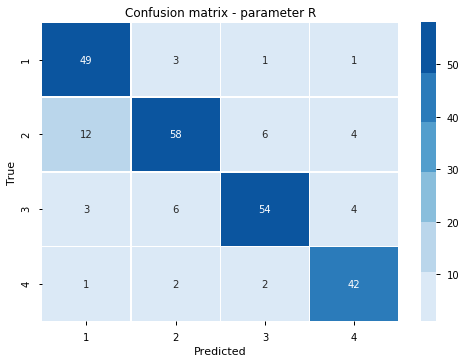

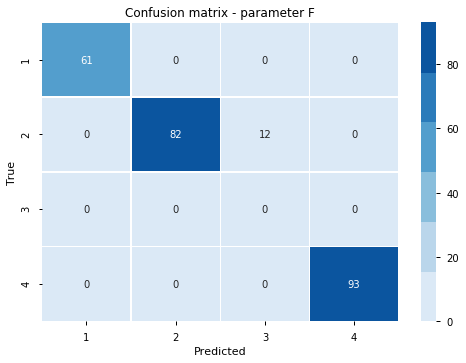

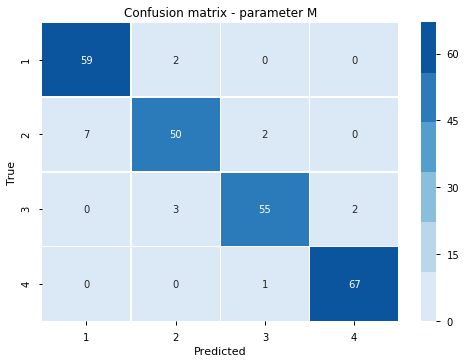

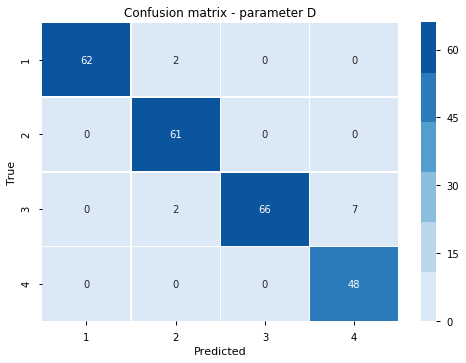

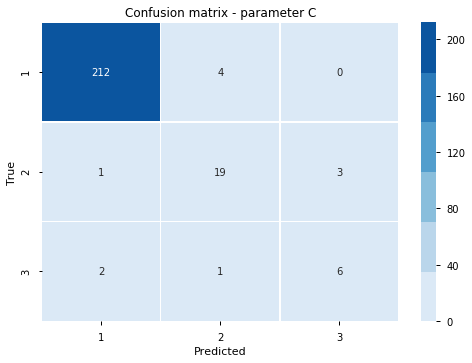

In [48]:
#Confusion matrix
labelsdict = {'R':[1,2,3,4], 'F':[1,2,3,4], 'M':[1,2,3,4], 'D':[1,2,3,4], 'C':[1,2,3]}
for parameter, classif in rfcdict.items():
    labels = labelsdict[parameter]
    confmatrix = confusion_matrix(classif.predict(X_test_scaled), ytest[parameter], labels)
    ax = sns.heatmap(confmatrix, linewidths=.5, annot=True, fmt="d", cmap = sns.color_palette("Blues"))
    plt.title('Confusion matrix - parameter {}'.format(parameter))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()
    #print(confmatrix)

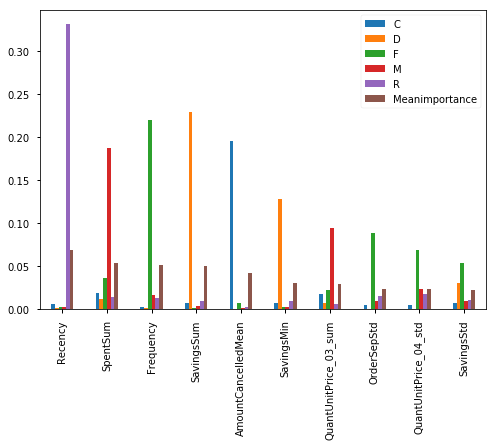

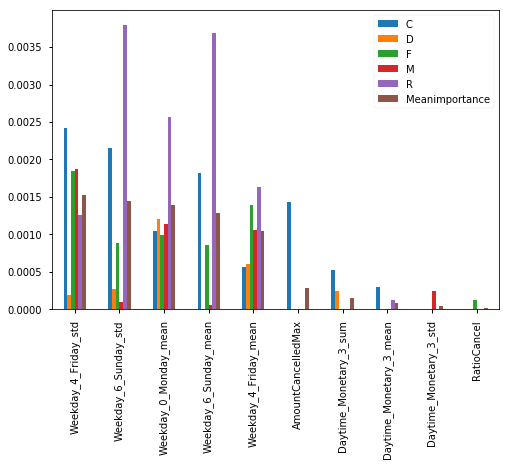

In [49]:
#Feature importance for all the features
featimpRFC = pd.DataFrame(data=featureimportancedictRFC, index = variables)
featimpRFC['Meanimportance'] = featimpRFC.apply(np.mean, axis = 1)
featimpRFC = featimpRFC.sort_values('Meanimportance', ascending = False)
featimpRFC[:10].plot(kind = 'bar')
plt.show()

featimpRFC[-10:].plot(kind = 'bar')
plt.show()

In [50]:
rfcdict

{'C': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=9, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'D': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=6, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'F': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=8, max_features='sqrt', max_leaf_